# Trabajo Práctico 2

Para la imagen suministrada “metal grid ”. Implementar un algoritmo
1. Calcule los gradientes en la imagen (dirección y módulo)
2. Muestre imágenes de ángulo y módulo
3. Marque con color las direcciones de gradientes más altos

In [3]:
# Importar librerías
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


Tamaño imagen: (350, 735, 3) pix


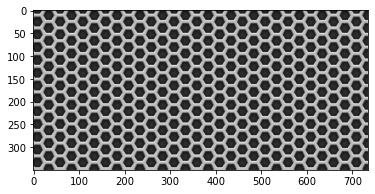

In [30]:
img = cv.imread('metalgrid.jpg')
print('\nTamaño imagen: {} pix'.format(img.shape))
img_rgb = img_gray = cv.cvtColor(img,cv.COLOR_BGR2RGB)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')
plt.show()

In [31]:
# Aplicamos un filtro de suavizado gaussiano
img_gray = cv.GaussianBlur(gray,(5,5),0)

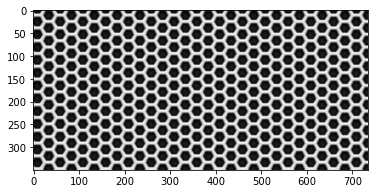

In [32]:
plt.imshow(img_gray,cmap='gray')

## Ejercicio 1

In [33]:
# Gradientes
#===========

# Aplicamos Sobelx en 'float32' y luego convertimos de nuevo a 8-bit para evitar overflow
sobelx_64 = cv.Sobel(img_gray,cv.CV_32F,1,0,ksize=3)
absx_64 = np.absolute(sobelx_64)
sobelx_8u1 = absx_64/absx_64.max()*255
sobelx_8u = np.uint8(sobelx_8u1)

# De igual modo para Sobely
sobely_64 = cv.Sobel(img_gray,cv.CV_32F,0,1,ksize=3)
absy_64 = np.absolute(sobely_64)
sobely_8u1 = absy_64/absy_64.max()*255
sobely_8u = np.uint8(sobely_8u1)

# De los gradiente calculamos Magnitud y lo pasamos a 8-bit (Opcional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255
mag = np.uint8(mag)

# Encontramos la Dirección y la pasamos a grados
theta = np.arctan2(sobely_64, sobelx_64)
angle = np.rad2deg(theta)

## Ejercicio 2

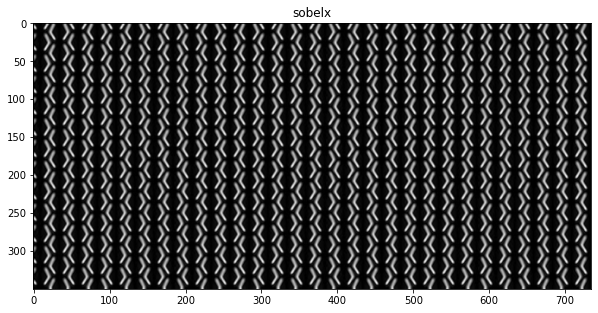

In [34]:
plt.subplots(figsize=(10,10))
plt.title('sobelx')
plt.imshow(sobelx_8u,cmap='gray')

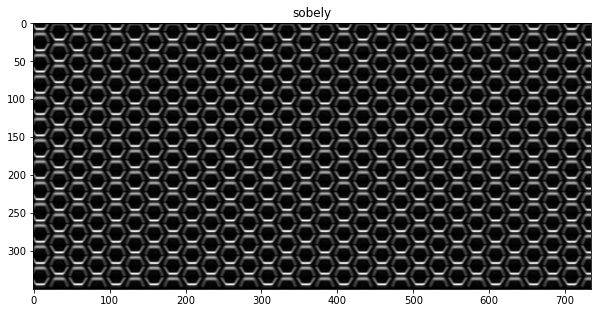

In [35]:
plt.subplots(figsize=(10,10))
plt.title('sobely')
plt.imshow(sobely_8u,cmap='gray')

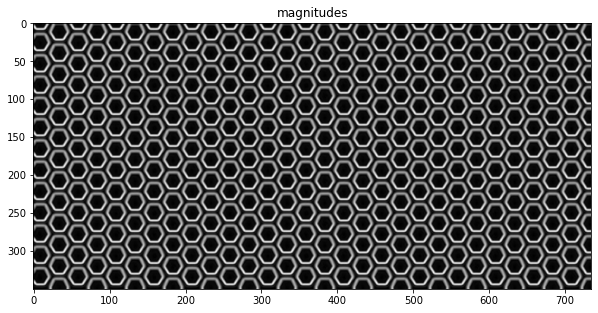

In [36]:
plt.subplots(figsize=(10,10))
plt.title('magnitudes')
plt.imshow(mag,cmap='gray')

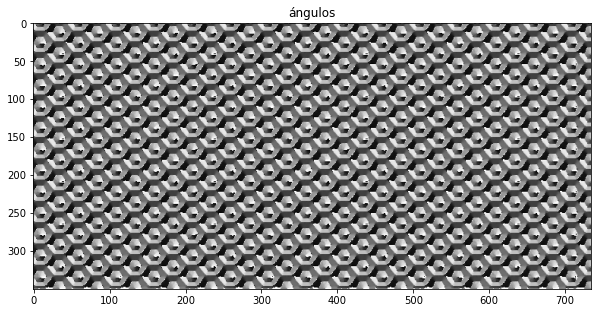

In [37]:
plt.subplots(figsize=(10,10))
plt.title('ángulos')
plt.imshow(angle,cmap='gray')

## Ejercicio 3

In [38]:
# Supresión de no-máximos
#========================
# Encontramos los píxels vecinos (b,c) en la dirección (redondeadea) del gradiente y aplicamos la supresión de no-máximos
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)

for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Supresión de no-máximos
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0


In [45]:
# Umbralizado por histéresis
#===========================

UmbralAlto = 150
UmbralBajo = 30

M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)

# Si la intensidad de un borde es mayor a 'UmbralAlto' es seguro un umbral, debajo de 'UmbralBajo' seguro no es
strong_i, strong_j = np.where(Non_max >= UmbralAlto)
zeros_i, zeros_j = np.where(Non_max < UmbralBajo)

# Bordes débiles
weak_i, weak_j = np.where((Non_max <= UmbralAlto) & (Non_max >= UmbralBajo))

# Setear el mismo valor a todos los tipos de píxel
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75


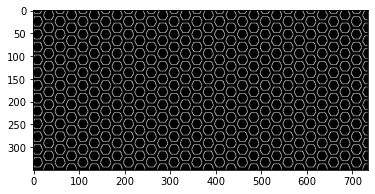

In [46]:
# Armo la imagen de bordes
#=========================
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

# Muestro la imagen
#==================
plt.imshow(out, cmap='gray')


In [56]:
def plot_borders(angle, original_img, canny_img, borders):
    M, N, L = original_img.shape
    input_img2 = original_img.copy()
    canny_img2 = canny_img.copy()
    if borders == 'hor':
        for i in range(1,M-1):
            for j in range(1,N-1):
                if ((85 <= angle[i,j] < 95) or (-95 <= angle[i,j] <= -85)) and canny_img[i,j]>0:
                    input_img2[i, j,0] = 255

    elif borders == 'vert':
        for i in range(1,M-1):
            for j in range(1,N-1):
                if ((-45 <= angle[i,j] < 45) or (-180 <= angle[i,j] < -135) or (135 <= angle[i,j] < 180)) and canny_img[i,j]>0:
                    input_img2[i, j,0] = 255

    
    plt.subplots(figsize=(20,20))
    plt.imshow(input_img2)

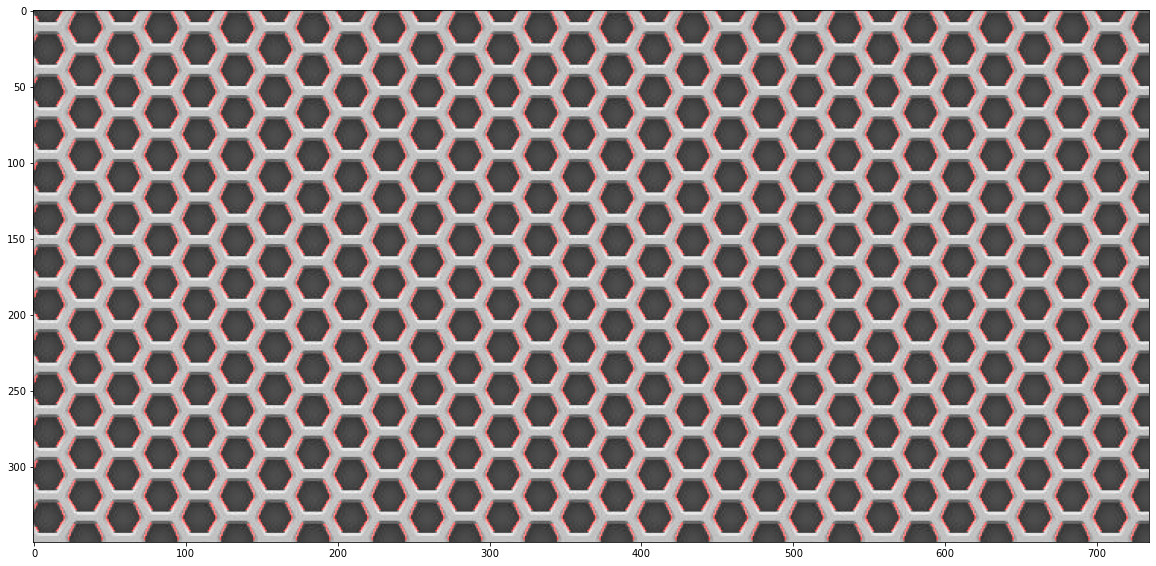

In [57]:
plot_borders(angle=angle,original_img=img_rgb,canny_img=out,borders='vert')

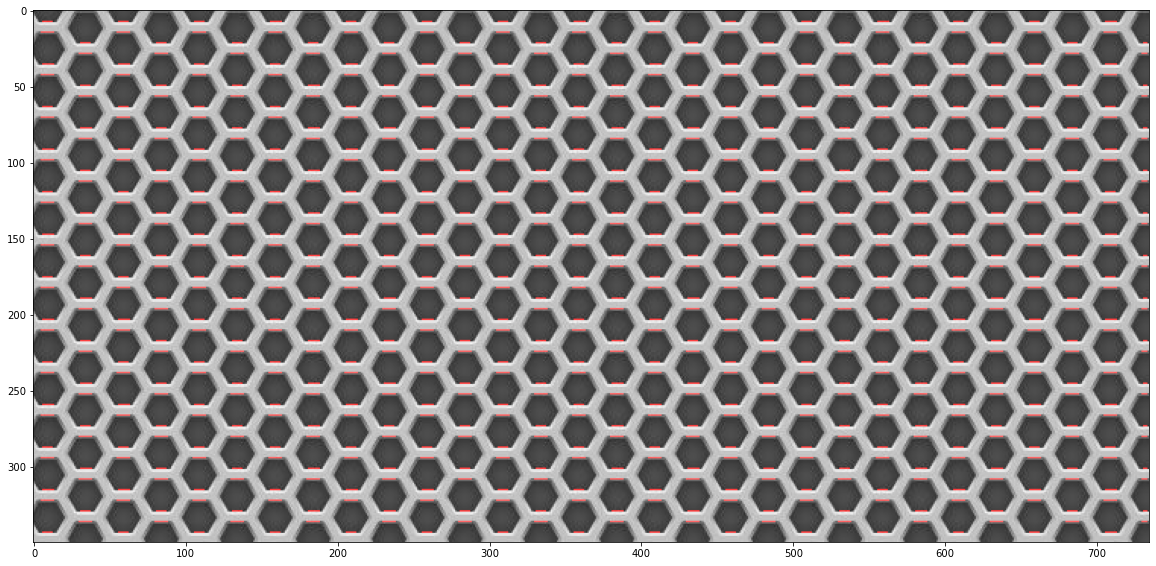

In [58]:
plot_borders(angle=angle,original_img=img_rgb,canny_img=out,borders='hor')